## Import

In [1]:
!pip install -q numpy
!pip install -q matplotlib
!pip install -q mujoco
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

%env MUJOCO_GL=egl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.1 MB/s eta 0:00:00
env: MUJOCO_GL=egl


In [2]:
import os
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
import mujoco

# MuJoCo 환경 구축

- mujoco에서는 xml 파일안에 환경 설정을 할 수 있다.
- xml 파일의 최상위 Tag `<mujoco>`
- 모든 물리 요소들은 `<worldbody>` 안에 정의
- `<from_xml_string()>`을 통해 mjModel로 변환

In [4]:
xml_string="""<mujoco model="cheetah">
  <compiler angle="radian" coordinate="local" inertiafromgeom="true" settotalmass="14"/>
  <default>
    <joint armature=".1" damping=".01" limited="true" solimplimit="0 .8 .03" solreflimit=".02 1" stiffness="8"/>
    <geom conaffinity="0" condim="3" contype="1" friction=".4 .1 .1" rgba="0.8 0.6 .4 1" solimp="0.0 0.8 0.01" solref="0.02 1"/>
    <motor ctrllimited="true" ctrlrange="-1 1"/>
  </default>
  <size nstack="300000" nuser_geom="1"/>
  <option gravity="0 0 -9.81" timestep="0.01"/>
  <asset>
    <texture builtin="gradient" height="100" rgb1="1 1 1" rgb2="0 0 0" type="skybox" width="100"/>
    <texture builtin="flat" height="1278" mark="cross" markrgb="1 1 1" name="texgeom" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
    <texture builtin="checker" height="100" name="texplane" rgb1="0 0 0" rgb2="0.8 0.8 0.8" type="2d" width="100"/>
    <material name="MatPlane" reflectance="0.5" shininess="1" specular="1" texrepeat="60 60" texture="texplane"/>
    <material name="geom" texture="texgeom" texuniform="true"/>
  </asset>
  <worldbody>
    <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
    <geom conaffinity="1" condim="3" material="MatPlane" name="floor" pos="0 0 0" rgba="0.8 0.9 0.8 1" size="40 40 40" type="plane"/>
    <body name="torso" pos="0 0 .7">
      <camera name="track" mode="trackcom" pos="0 -3 0.3" xyaxes="1 0 0 0 0 1"/>
      <joint armature="0" axis="1 0 0" damping="0" limited="false" name="rootx" pos="0 0 0" stiffness="0" type="slide"/>
      <joint armature="0" axis="0 0 1" damping="0" limited="false" name="rootz" pos="0 0 0" stiffness="0" type="slide"/>
      <joint armature="0" axis="0 1 0" damping="0" limited="false" name="rooty" pos="0 0 0" stiffness="0" type="hinge"/>
      <geom fromto="-.5 0 0 .5 0 0" name="torso" size="0.046" type="capsule"/>
      <geom axisangle="0 1 0 .87" name="head" pos=".6 0 .1" size="0.046 .15" type="capsule"/>
      <!-- <site name='tip'  pos='.15 0 .11'/>-->
      <body name="bthigh" pos="-.5 0 0">
        <joint axis="0 1 0" damping="6" name="bthigh" pos="0 0 0" range="-.52 1.05" stiffness="240" type="hinge"/>
        <geom axisangle="0 1 0 -3.8" name="bthigh" pos=".1 0 -.13" size="0.046 .145" type="capsule"/>
        <body name="bshin" pos=".16 0 -.25">
          <joint axis="0 1 0" damping="4.5" name="bshin" pos="0 0 0" range="-.785 .785" stiffness="180" type="hinge"/>
          <geom axisangle="0 1 0 -2.03" name="bshin" pos="-.14 0 -.07" rgba="0.9 0.6 0.6 1" size="0.046 .15" type="capsule"/>
          <body name="bfoot" pos="-.28 0 -.14">
            <joint axis="0 1 0" damping="3" name="bfoot" pos="0 0 0" range="-.4 .785" stiffness="120" type="hinge"/>
            <geom axisangle="0 1 0 -.27" name="bfoot" pos=".03 0 -.097" rgba="0.9 0.6 0.6 1" size="0.046 .094" type="capsule"/>
          </body>
        </body>
      </body>
      <body name="fthigh" pos=".5 0 0">
        <joint axis="0 1 0" damping="4.5" name="fthigh" pos="0 0 0" range="-1 .7" stiffness="180" type="hinge"/>
        <geom axisangle="0 1 0 .52" name="fthigh" pos="-.07 0 -.12" size="0.046 .133" type="capsule"/>
        <body name="fshin" pos="-.14 0 -.24">
          <joint axis="0 1 0" damping="3" name="fshin" pos="0 0 0" range="-1.2 .87" stiffness="120" type="hinge"/>
          <geom axisangle="0 1 0 -.6" name="fshin" pos=".065 0 -.09" rgba="0.9 0.6 0.6 1" size="0.046 .106" type="capsule"/>
          <body name="ffoot" pos=".13 0 -.18">
            <joint axis="0 1 0" damping="1.5" name="ffoot" pos="0 0 0" range="-.5 .5" stiffness="60" type="hinge"/>
            <geom axisangle="0 1 0 -.6" name="ffoot" pos=".045 0 -.07" rgba="0.9 0.6 0.6 1" size="0.046 .07" type="capsule"/>
          </body>
        </body>
      </body>
    </body>
  </worldbody>
  <actuator>
    <motor gear="120" joint="bthigh" name="bthigh"/>
    <motor gear="90" joint="bshin" name="bshin"/>
    <motor gear="60" joint="bfoot" name="bfoot"/>
    <motor gear="120" joint="fthigh" name="fthigh"/>
    <motor gear="60" joint="fshin" name="fshin"/>
    <motor gear="30" joint="ffoot" name="ffoot"/>
  </actuator>
</mujoco>"""

# MuJoCo 모델 Load
- mujoco.MjModel.`from_xml_string`
  - 모델 관련 모든 설명을 모두 포함하는 객체
  - `from_xml_string` : xml을 `string` type으로 입력시 mjModel을 만들어 주는 방법

- mujoco.MjData
  - MjData : 각각의 파트의 상태치를 포함하는 객체, 특정 시간에서 각각 파트의 위치, 속도, 가속도 등을 포함
  - 시간 정보 : `date.time`
  - 위치 정보 : `date.qpos`
  - 속도 정보 : `date.qvel`
  

In [5]:
model = mujoco.MjModel.from_xml_string(xml_string)
data = mujoco.MjData(model)
mujoco.mj_resetData(model, data)
renderer = mujoco.Renderer(model)

init_qpos = data.qpos.ravel().copy()
init_qvel = data.qvel.ravel().copy()
print(init_qpos, init_qvel)

[0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Visualize

- mujoco.mj_resetData : 모델, 데이터를 초기화
- mujoco.mj_step : forward simulation을 1 step 이동시킴. $x_{t+h} = f(x_t)$
- renderer.update_scene : data를 기반으로 scene 생성
- renderer.render : image 생성

In [6]:
duration = 1.  # (seconds)
framerate = 50  # (Hz)

frames = [] # 이미지를 저장할 리스트
mujoco.mj_resetData(model, data)
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data,0) # 두번째 파라미터 = 카메라 번호
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

# Observation

- 현재 위치와 속도 정의


In [7]:
def get_obs(data):
  position = data.qpos.flat.copy()
  velocity = data.qvel.flat.copy()
  position = position[1:] # 어차피 치타는 x축을 따라서 이동할 것이므로 x축 좌표를 제외함
  observation = np.concatenate((position, velocity)).ravel()
  return observation

obs = get_obs(data)
print(len(obs))
print(obs)

17
[-0.12758689  0.0507151   0.02089165  0.05755089 -0.02685161 -0.04588718
 -0.12902735 -0.12109846 -0.01516881 -0.00875182  0.00663431  0.00948863
  0.01278586 -0.00395083 -0.05661198 -0.02123475 -0.00360931]


# Action

- 각 축에 있는 모터의 토크를 제어함 (6차원)
- -1 ~ 1의 값을 가짐

In [8]:
def sample_action(max, min, dim):
  return (max-min)*np.random.uniform(size=(dim,)) +min

act = sample_action(1,-1,6)
print(act)

[-0.00745567  0.98228698  0.15105367 -0.51761099  0.72036898  0.24076476]


# Transition

- One Step Simulation을 통해 Next Observation을 찾음

""

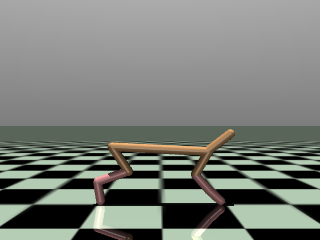

[-0.12758689  0.0507151   0.02089165  0.05755089 -0.02685161 -0.04588718
 -0.12902735 -0.12109846 -0.01516881 -0.00875182  0.00663431  0.00948863
  0.01278586 -0.00395083 -0.05661198 -0.02123475 -0.00360931]


""

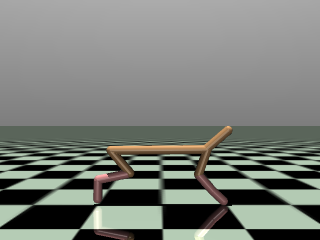

[-0.13369462 -0.03008401 -0.05127862  0.38406868  0.04333176 -0.21473265
  0.12782317 -0.08998515 -0.59157524 -0.1963831  -2.1804238  -1.04897545
  7.55145128  1.72043591 -4.52447207  7.11957717  1.58353313]


In [9]:
def step_mujoco_simulation(model, data, renderer, ctrl, n_frames):
  data.ctrl = ctrl
  mujoco.mj_step(model, data, nstep=n_frames)
  renderer.update_scene(data,0)

media.show_image(renderer.render())
print(get_obs(data))
step_mujoco_simulation(model, data, renderer, act, 5)
media.show_image(renderer.render())
print(get_obs(data))

상태의 변화를 확인할 수 있다

# Initial State Distribution

- 초기 위치, 초기 속도를 랜덤하게 설정(초기화)

In [10]:
def reset(model, data, _reset_noise_scale=0.1, init_qpos=init_qpos, init_qvel=init_qvel):
    noise_low = -_reset_noise_scale
    noise_high = _reset_noise_scale

    qpos = init_qpos + np.random.uniform(
        low=noise_low, high=noise_high, size=model.nq
    )
    qvel = (
        init_qvel
        + _reset_noise_scale * np.random.standard_normal(model.nv)
    )

    data.qpos[:] = np.copy(qpos)
    data.qvel[:] = np.copy(qvel)
    if model.na == 0:
        data.act[:] = None
        mujoco.mj_forward(model, data)

    observation = get_obs(data)
    return observation

print(reset(model, data))

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(model, data)
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data,0)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

[-0.03920404 -0.04670432  0.08072962 -0.08419017  0.05339897  0.08847755
  0.04096947  0.09077373  0.1087162  -0.12864159  0.04129536  0.03852593
 -0.04780799  0.07968162  0.01524964 -0.08595764  0.07064305]


# Reward

- 이 domain의 목표는 너무 큰 토크를 사용하지 않고 빠르게 전진하는 것

In [11]:
obs = get_obs(data)

# Control Penalty Rewards
ctrl_cost_weight = 0.1
control_cost = ctrl_cost_weight * np.sum(np.square(act)) # 너무 강하게 토크를 걸면 cost가 많이 쓰임

# Velocity Rewards
forward_reward_weight = 1.0
x_position_before = data.qpos[0]
step_mujoco_simulation(model, data, renderer, act, 5)
x_position_after = data.qpos[0]
x_velocity = (x_position_after - x_position_before) / model.opt.timestep / 5.
forward_reward = forward_reward_weight * x_velocity # 앞으로 빠르게 갈수록 reward를 크게 받음

print(f"Forward Reward: {forward_reward}, Control Cost: {control_cost:0.2f}")

Forward Reward: -0.4587041710257133, Control Cost: 0.18


# Env

In [12]:
class HalfCheetahEnv():
  def __init__(
      self,
      frame_skip=5,
      forward_reward_weight=1.0,
      ctrl_cost_weight=0.1,
      reset_noise_scale=0.1
      ):

    self.frame_skip = frame_skip
    self.forward_reward_weight = forward_reward_weight
    self.ctrl_cost_weight = ctrl_cost_weight
    self.reset_noise_scale = reset_noise_scale

    self.initialize_simulation()
    self.init_qpos = self.data.qpos.ravel().copy()
    self.init_qvel = self.data.qvel.ravel().copy()
    self.dt = self.model.opt.timestep * self.frame_skip

    self.observation_dim = 17
    self.action_dim = 6

  def initialize_simulation(self):
    self.model = mujoco.MjModel.from_xml_string(xml_string)
    self.data = mujoco.MjData(self.model)
    mujoco.mj_resetData(self.model, self.data)
    self.renderer = mujoco.Renderer(self.model)

  def reset_simulation(self):
    mujoco.mj_resetData(self.model, self.data)

  def step_mujoco_simulation(self, ctrl, n_frames):
    self.data.ctrl[:] = ctrl
    mujoco.mj_step(self.model, self.data, nstep=n_frames)
    self.renderer.update_scene(self.data,0)

  def set_state(self, qpos, qvel):
    self.data.qpos[:] = np.copy(qpos)
    self.data.qvel[:] = np.copy(qvel)
    if self.model.na == 0:
      self.data.act[:] = None
    mujoco.mj_forward(self.model, self.data)

  def sample_action(self):
    return 2.*np.random.uniform(size=(self.action_dim,)) - 1

  def step(self, action):
    x_position_before = self.data.qpos[0]
    self.step_mujoco_simulation(action, self.frame_skip)
    x_position_after = self.data.qpos[0]
    x_velocity = (x_position_after - x_position_before) / self.dt

    # Rewards
    ctrl_cost = self.ctrl_cost_weight * np.sum(np.square(action))
    forward_reward = self.forward_reward_weight * x_velocity
    observation = self.get_obs()
    reward = forward_reward - ctrl_cost
    terminated = False
    info = {
        "x_position": x_position_after,
        "x_velocity": x_velocity,
        "reward_run": forward_reward,
        "reward_ctrl": -ctrl_cost,
    }
    return observation, reward, terminated, info

  def get_obs(self):
    position = self.data.qpos.flat.copy()
    velocity = self.data.qvel.flat.copy()
    position = position[1:]

    observation = np.concatenate((position, velocity)).ravel()
    return observation

  def render(self):
    return self.renderer.render()

  def reset(self):
    self.reset_simulation()
    noise_low = -self.reset_noise_scale
    noise_high = self.reset_noise_scale
    qpos = self.init_qpos + np.random.uniform(
        low=noise_low, high=noise_high, size=self.model.nq
    )
    qvel = (
        self.init_qvel
        + self.reset_noise_scale * np.random.standard_normal(self.model.nv)
    )
    self.set_state(qpos, qvel)
    observation = self.get_obs()
    return observation

In [14]:
env = HalfCheetahEnv()
env.reset()
imgs = []

for _ in range(100):
  action = env.sample_action()
  next_observation, reward, terminated, info = env.step(action)
  img = env.render()
  imgs.append(img)

media.show_video(imgs, fps=1/env.dt)